In [1]:
## Question 3 of Assignment 2
import torch
import torch.nn.functional as F

def scaled_dot_product_attention(Q, K, V):
    # d_k is the dimension of the keys
    d_k = Q.size(-1)

    # Compute dot product and scale
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

    # Apply softmax to get attention weights
    weights = F.softmax(scores, dim=-1)

    # Multiply by values
    output = torch.matmul(weights, V)

    return output, weights

In [2]:
## Question 4 of Assignment 2
def masked_attention(Q, K, V):
    d_k = Q.size(-1)
    seq_len = Q.size(-2)

    # Compute scores
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

    # Create causal mask (1s on and below diagonal, 0s above)
    mask = torch.tril(torch.ones(seq_len, seq_len))

    # Set future entries (0s in mask) to -inf
    masked_scores = scores.masked_fill(mask == 0, float('-inf'))

    # Apply softmax; e^-inf is 0, effectively masking those positions
    weights = F.softmax(masked_scores, dim=-1)

    output = torch.matmul(weights, V)

    return output, weights

# --- Demonstration of Masking ---
Q_demo = torch.randn(1, 3, 64) # Batch size 1, Sequence length 3
_, weights = masked_attention(Q_demo, Q_demo, Q_demo)
print("Attention Weight Matrix:\n", weights)
# You will notice the upper triangle of the matrix is all zeros.

Attention Weight Matrix:
 tensor([[[1.0000e+00, 0.0000e+00, 0.0000e+00],
         [4.7626e-06, 1.0000e+00, 0.0000e+00],
         [1.3114e-03, 6.1578e-04, 9.9807e-01]]])


**Reason for Masking**

By setting the "future" entries in the score matrix to -inf, the softmax function forces those probabilities to exactly 0.

As seen in the demonstration output, the weight matrix will be lower-triangular. For example, the first token can only attend to itself, preventing it from "seeing" the second or third words in the sequence during training.

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

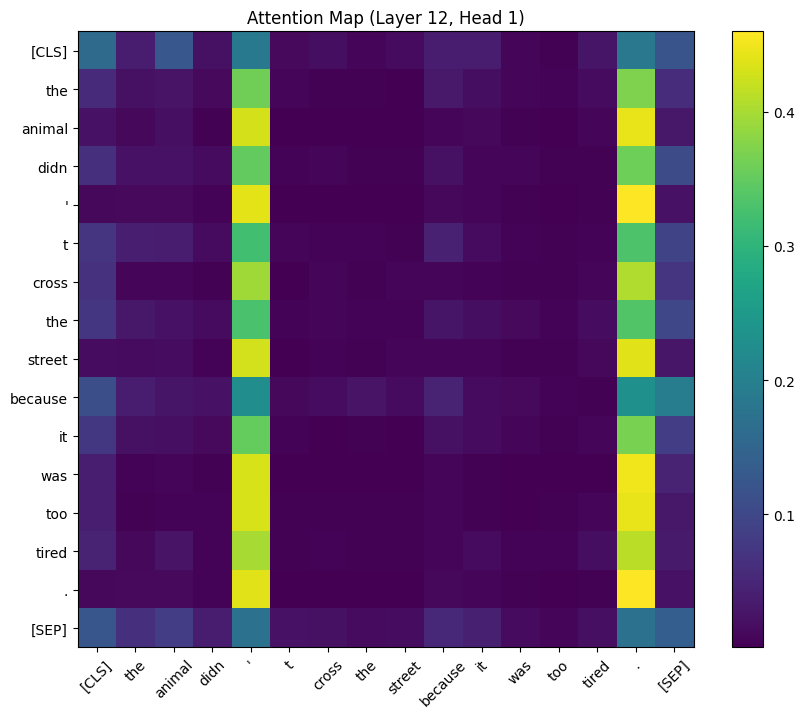

In [3]:
## Question 5 of Assignment 2

from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import torch

# 1. Load model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

# 2. Process sentence
sentence = "The animal didn't cross the street because it was too tired."
inputs = tokenizer(sentence, return_tensors='pt')
outputs = model(**inputs)

# 3. Extract attention (from the last layer, first head)
# Shape: [layer][batch, head, seq, seq]
attention = outputs.attentions[-1][0, 0].detach().numpy()
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# 4. Plot Heatmap
plt.figure(figsize=(10, 8))
plt.imshow(attention, cmap='viridis')
plt.xticks(range(len(tokens)), tokens, rotation=45)
plt.yticks(range(len(tokens)), tokens)
plt.colorbar()
plt.title("Attention Map (Layer 12, Head 1)")
plt.show()